## This notebook will take all essays and map their scores between 0 to 1

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

%matplotlib inline

In [2]:
training_tsv = 'training_set_rel3.tsv'
valid_tsv = 'valid_set.tsv'
test_tsv = 'test_set.tsv'

df_params = {'delimiter': '\t', 'encoding': 'ansi'}


In [3]:

df_training = pd.read_csv(training_tsv, **df_params)
df_valid = pd.read_csv(valid_tsv, **df_params)
df_test = pd.read_csv(test_tsv, **df_params)

# do not Append all dataframes to one another so you get one big dataframe
# since validation and test dataframes don't have domain1_score column

df_training.head()

,essay_id,essay_set,essay,rater1_domain1,rater2_domain1,rater3_domain1,domain1_score,rater1_domain2,rater2_domain2,domain2_score,...,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6
0,1,1,"Dear local newspaper, I think effects computer...",4,4,NaN,8,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5,4,NaN,9,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4,3,NaN,7,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",5,5,NaN,10,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1,"Dear @LOCATION1, I know having computers has a...",4,4,NaN,8,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
def remove_unneeded(df):
    df = df[['essay_id', 'essay_set', 'essay', 'domain1_score',]]
    
    # ONLY SELECT ESSAY SETS 3 4 5 6 ie 150 words
    # https://chrisalbon.com/python/data_wrangling/pandas_select_rows_when_column_has_certain_values/
    df = df[ df['essay_set'].isin([3, 4, 5, 6]) ]
    return df

# Apply the function to df
df_training = remove_unneeded(df_training)
print(df_training.info())
df_training.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7101 entries, 3583 to 10683
Data columns (total 4 columns):
essay_id         7101 non-null int64
essay_set        7101 non-null int64
essay            7101 non-null object
domain1_score    7101 non-null int64
dtypes: int64(3), object(1)
memory usage: 277.4+ KB
None


,essay_id,essay_set,essay,domain1_score
3583,5978,3,The features of the setting affect the cyclist...,1
3584,5979,3,The features of the setting affected the cycli...,2
3585,5980,3,Everyone travels to unfamiliar places. Sometim...,1
3586,5981,3,I believe the features of the cyclist affected...,1
3587,5982,3,The setting effects the cyclist because of the...,2


In [5]:
import re
def add_dense_sparse_features(df):
    # refer to kenton murray papers
    essay = df['essay']
    df['char_count'] = essay.apply(len)
    df['words'] = essay.apply(lambda x: len(re.split(r'\W+', x)))
    return df

# Apply function to df
df_training = add_dense_sparse_features(df_training)
print(df_training.info())
print(df_training.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7101 entries, 3583 to 10683
Data columns (total 6 columns):
essay_id         7101 non-null int64
essay_set        7101 non-null int64
essay            7101 non-null object
domain1_score    7101 non-null int64
char_count       7101 non-null int64
words            7101 non-null int64
dtypes: int64(5), object(1)
memory usage: 388.3+ KB
None
      essay_id  essay_set                                              essay  \
3583      5978          3  The features of the setting affect the cyclist...   
3584      5979          3  The features of the setting affected the cycli...   
3585      5980          3  Everyone travels to unfamiliar places. Sometim...   
3586      5981          3  I believe the features of the cyclist affected...   
3587      5982          3  The setting effects the cyclist because of the...   

      domain1_score  char_count  words  
3583              1         264     52  
3584              2        1016    180  
3585  

In [6]:
# Normalize score data

def normalize_score(df):
    print('Before')
    print(df['domain1_score'].head())
    print(df.describe())
    
    max_scores = dict()
    ##################OPTIMIZE########VERY SLOW########
    for _, row in df.iterrows():
        essay_set = row['essay_set']
        _sliced = df[df['essay_set'] == essay_set]
        
        # Find the max of the score
        max_scores[essay_set] = max(_sliced['domain1_score'] ) - min(_sliced['domain1_score']) + 1

    
    print(type(df))
    df['domain1_score'] = df.apply(axis=1, func=lambda row: row['domain1_score'] / max_scores[row['essay_set']])
    print(type(df))
    print('MAX SCORES', max_scores)
    
    return df
df_training = normalize_score(df_training)
print('After')
print(df_training.head())
print(df_training.describe())

Before
3583    1
3584    2
3585    1
3586    1
3587    2
Name: domain1_score, dtype: int64
           essay_id    essay_set  domain1_score   char_count        words
count   7101.000000  7101.000000    7101.000000  7101.000000  7101.000000
mean   11317.494437     4.518096       2.108013   670.460217   121.882974
std     3345.669269     1.114875       1.052573   345.534816    59.447280
min     5978.000000     3.000000       0.000000     8.000000     2.000000
25%     8912.000000     4.000000       1.000000   393.000000    75.000000
50%    11881.000000     5.000000       2.000000   642.000000   118.000000
75%    14858.000000     6.000000       3.000000   904.000000   162.000000
max    16633.000000     6.000000       4.000000  2718.000000   464.000000
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
MAX SCORES {3: 4, 4: 4, 5: 5, 6: 5}
After
      essay_id  essay_set                                              essay  \
3583      5978          3  The features of th

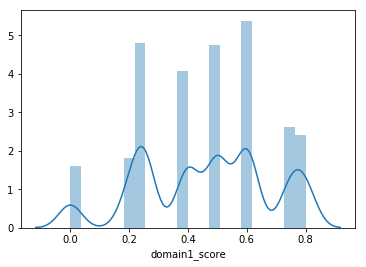

In [7]:
# How the scores are distributed
sns.distplot(df_training['domain1_score'])

In [8]:
######## START ACTUAL ML
X = df_training[['char_count', 'words']]
y = df_training['domain1_score']


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [10]:
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

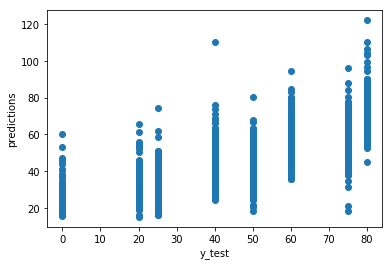

In [11]:
predictions = lm.predict(X_test)
plt.xlabel('y_test')
plt.ylabel('predictions')
plt.scatter(y_test*100,predictions*100)


[Text(0.5, 0, 'difference (predicted vs actual)')]

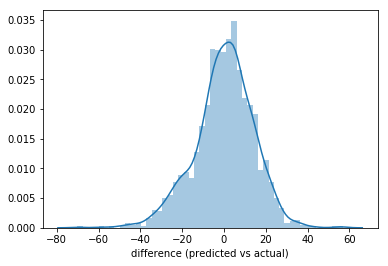

In [12]:
ax = sns.distplot((y_test-predictions)*100,bins=50)
ax.set(xlabel='difference (predicted vs actual)')

In [13]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 0.10884967250678584
MSE: 0.02020221179720215
RMSE: 0.14213448489793795


In [14]:
df_training.to_csv('filtered_train.csv', encoding='utf8')